In [1]:
# Use svg graphics, display inline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import glob
import re
import copy
import sys

# Basic scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hex colors for plotting
FB_BLUE = '#1877F2'
FB_HERITAGE_BLUE = '#3B5998'
FB_LIGHT_BLUE = '#8B9DC3'
FB_VERY_LIGHT_BLUE = '#dfE3EE'
SOFT_RED = '#C23F38'
SOFT_GREEN = '#56B000'
NEUTRAL_GREY = '#A9A9A9'
GGPLOT_PALETTE = [
	'#F8766F', '#E58700', '#C99800', '#A3A500', '#6BB100',
	'#00BA38', '#00BF7D', '#00C0AF', '#00BCD8', '#00B0F6',
	'#619CFF', '#B983FF', '#E76BF3', '#FD61D1', '#FF67A4'
]

# display config
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.options.display.max_rows = 999
plt.style.use('default')
plt.rcParams['figure.figsize'] = 10, 6
plt.style.use('ggplot')
np.set_printoptions(suppress=True)

from string import ascii_lowercase
from statsmodels.stats.weightstats import ztest
import calendar
import wikipedia
from bs4 import BeautifulSoup
import requests

from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import f_oneway, mannwhitneyu
import statsmodels.api as sm

print(sys.version)

3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]


In [2]:
file_paths = glob.glob('./Final/*.tsv')
df_raw = pd.concat([pd.read_csv(file_path, sep='\t') for file_path in file_paths])
    
df_raw.sample(3)

,fbid,sentence1_lang,sentence2_lang,sentence1,sentence1_incoherence,sentence2,sentence2_incoherence,sts_score,evaluator_id
541,5058690_3v,eng,zho_Hans,"Some 31,900,000 square feet (2,960,000 m2) of ...",0,"大约 31,900,000 平方英尺（2,960,000 平方米）的曼哈顿下城办公空间遭到损...",0,4,L.I
734,61567171_3t,eng,zul,"Keanu Reeves, Carrie-Anne Moss, and Jada Pinke...",0,"UKeanu Reeves, Carrie-Anne Moss, noJada Pinket...",0,4,K.R
422,3524766_3i,eng,lug,"In Libya and Egypt, it was blamed for violent ...",0,"Mu Libya ne Misiri, kyavunaanibwa olw'okwekala...",0,4,ML


Helpers

In [3]:
def get_platform(fbid):
    
    fb_letters = [x for i, x in enumerate(list(ascii_lowercase)) if (i+1) % 2 != 0]    
    return 'facebook' if fbid[-1] in fb_letters else 'google'

code_to_lang = {
    'zho_Hans': 'Chinese',
    'isl': 'Icelandic',
    'hau': 'Hausa',
    'ibo': 'Igbo',
    'zul': 'Zulu',
    'oci': 'Occitan',
    'lug': 'Luganda'
}

In [4]:
df = (
    df_raw
    .rename(columns={
        'sentence1_lang': 'source_lang',
        'sentence2_lang': 'target_lang',
        'sentence1': 'source_segment',
        'sentence2': 'target_segment',
        'sentence1_incoherence': 'source_incoherence',
        'sentence2_incoherence': 'target_incoherence',
        'sts_score': 'score'
    })
    .assign(
        platform=lambda df_: df_.fbid.apply(get_platform),
        paragraph_id=lambda df_: df_.fbid.str.split('_', expand=True)[0],
        sentence_id=lambda df_: df_.fbid.str.slice(start=0, stop=-1),
        target_lang_full=lambda df_: df_.target_lang.apply(lambda x: code_to_lang[x])
    )
    .drop(['source_lang', 'evaluator_id'], axis=1)
    .groupby([
        'fbid', 
        'target_lang',
        'target_lang_full',
        'source_segment', 
        'target_segment', 
        'platform', 
        'paragraph_id', 
        'sentence_id'
    ])
    .median()
    .astype(int)
    .reset_index()
)

df.sample(3)

,fbid,target_lang,target_lang_full,source_segment,target_segment,platform,paragraph_id,sentence_id,source_incoherence,target_incoherence,score
3399,43836011_11k,ibo,Igbo,"In March 2021, a woman falsely claimed to be m...","Na Machị 2021, otu nwanyị kwuru n'ụzọ ụgha na ...",facebook,43836011,43836011_11,0,0,5
27,10093585_3j,ibo,Igbo,Her aunt Nina Temple was the last General Secr...,Nwanne nne ya Nina Temple bụ odeakwụkwọ ukwu i...,google,10093585,10093585_3,0,0,4
3197,40854965_1q,lug,Luganda,Platt was nominated for an Outer Critics Circl...,Platt yalondeddwa ku Outer Critics Circle Awar...,facebook,40854965,40854965_1,0,0,2


Sanity check. There should be 511 segments for each `(language, platform)` tuple

In [5]:
(df
    .groupby(['target_lang_full', 'platform'])
    .fbid
    .nunique()
    .to_frame()
)

fbid
target_lang_full platform      
Chinese          facebook   511
                 google     511
Hausa            facebook   511
                 google     511
Icelandic        facebook   511
                 google     511
Igbo             facebook   511
                 google     511
Luganda          facebook   511
Occitan          facebook   511
Zulu             facebook   511
                 google     511

In [7]:
(df
    .groupby(['target_lang_full', 'platform'])
    .score
     .agg([
        ('mean', np.mean),
        ('perc_acceptable', lambda x: np.mean(x >= 3)),
        ('perc_perfect', lambda x: np.mean(x == 5))
     ])
)

mean  perc_acceptable  perc_perfect
target_lang_full platform                                       
Chinese          facebook 4.13503          0.99609       0.43053
                 google   4.21135          0.99413       0.46184
Hausa            facebook 4.33268          0.99804       0.33855
                 google   4.35421          1.00000       0.35616
Icelandic        facebook 4.54990          0.99413       0.69080
                 google   4.39922          0.99609       0.57926
Igbo             facebook 4.36791          0.99609       0.51076
                 google   4.27202          0.99217       0.43640
Luganda          facebook 3.56556          0.88258       0.18395
Occitan          facebook 4.27202          0.97065       0.48337
Zulu             facebook 4.08806          0.94325       0.27789
                 google   4.12720          0.95499       0.31115

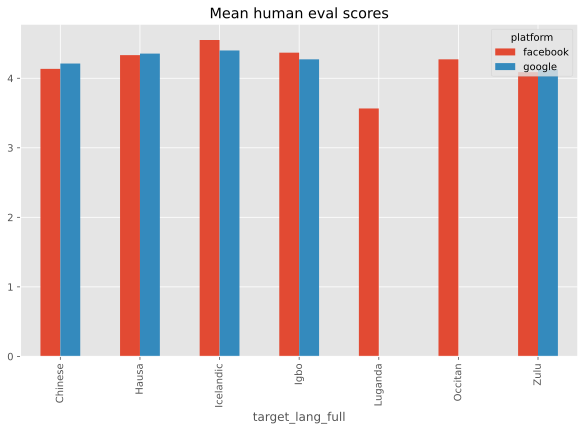

In [8]:
(df
    .groupby(['target_lang_full', 'platform'])
    .score
    .mean()
    .unstack()
    .plot.bar(title='Mean human eval scores')
);

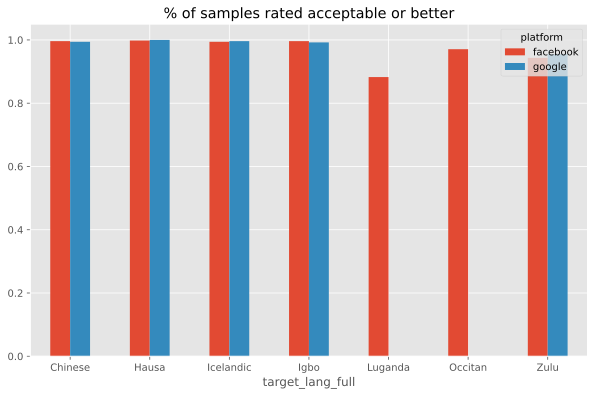

In [9]:
(df
    .pivot_table(
        'score', 
        index='target_lang_full', 
        columns='platform',
        aggfunc=lambda x: np.mean(x >= 3)
    )
    .plot.bar(title='% of samples rated acceptable or better', rot=0)
);

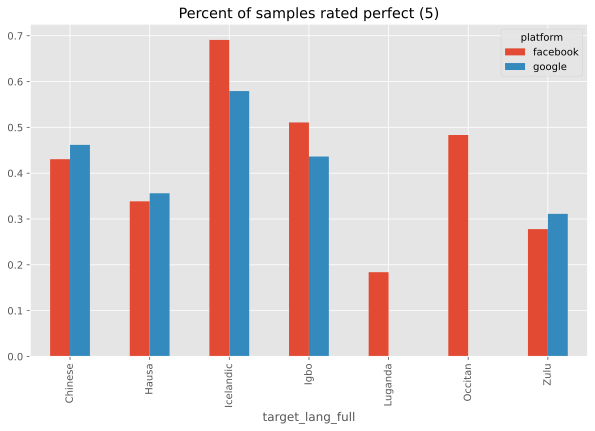

In [10]:
(df
    .pivot_table(
        'score', 
        index='target_lang_full', 
        columns='platform',
        aggfunc=lambda x: np.mean(x == 5)
    )
    .plot.bar(title='Percent of samples rated perfect (5)')
);

In [11]:
rows = []
for lang in ['zho_Hans', 'isl', 'hau', 'ibo', 'zul']:
    fb_scores = df[(df.target_lang == lang) & (df.platform == 'facebook')].score
    fb_mean = fb_scores.mean()
    
    google_scores = df[(df.target_lang == lang) & (df.platform == 'google')].score
    google_mean = google_scores.mean()
    
    z_score, p_val = ztest(
        fb_scores,
        google_scores
    )
    
    row = {
        'language': lang,
        'fb_mean': fb_mean,
        'google_mean': google_mean,
        'fb_se': np.sqrt(fb_scores.var() / len(fb_scores)),
        'google_se': np.sqrt(google_scores.var() / len(google_scores)),
        'diff_in_means': fb_mean - google_mean,
        'fb_is_better': (fb_mean - google_mean) > 0,
        'is_stat_sig': p_val < 0.05,
        'p_val': p_val,
        'z_score': z_score,
        'sample_size': len(google_scores)
    }
    
    rows.append(row)
    
df_diffs = pd.DataFrame(rows)
df_diffs

,language,fb_mean,google_mean,fb_se,google_se,diff_in_means,fb_is_better,is_stat_sig,p_val,z_score,sample_size
0,zho_Hans,4.13503,4.21135,0.03746,0.03650,-0.07632,False,False,0.14449,-1.45928,511
1,isl,4.54990,4.39922,0.03257,0.03474,0.15068,True,True,0.00156,3.16416,511
2,hau,4.33268,4.35421,0.02159,0.02136,-0.02153,False,False,0.47841,-0.70886,511
3,ibo,4.36791,4.27202,0.03212,0.03261,0.09589,True,True,0.03618,2.09491,511
4,zul,4.08806,4.12720,0.03353,0.03340,-0.03914,False,False,0.40826,-0.82696,511


/var/folders/c5/nkwg5qp52qb643c3zdsw3_dw0000gn/T/ipykernel_50337/2530480777.py:11: RuntimeWarning: Mean of empty slice.
  google_means = np.array([x.mean() for x in google_scores])
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/c5/nkwg5qp52qb643c3zdsw3_dw0000gn/T/ipykernel_50337/2530480777.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice
  google_ses = np.array([np.sqrt(x.var() / len(x)) for x in google_scores])
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


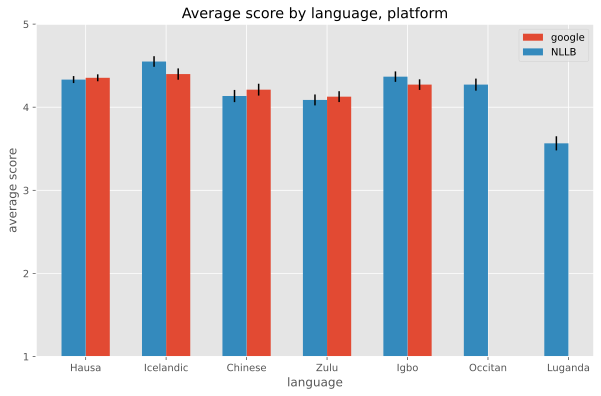

In [12]:
langs = 'hau isl zho_Hans zul ibo oci lug'.split()


fb_scores = [df[(df.target_lang == lang) & (df.platform == 'facebook')].score.values for lang in langs]
fb_means = np.array([x.mean() for x in fb_scores])
fb_ses = np.array([np.sqrt(x.var() / len(x)) for x in fb_scores])

fb_domain = np.arange(len(fb_means))

google_scores = [df[(df.target_lang == lang) & (df.platform == 'google')].score.values for lang in langs]
google_means = np.array([x.mean() for x in google_scores])
google_ses = np.array([np.sqrt(x.var() / len(x)) for x in google_scores])

google_domain = np.arange(len(google_means))

with plt.style.context('ggplot'):
    dot_size = 70
    bar_width=.3
    offset = bar_width / 2
    
    tick_domain = fb_domain
    ticks = [code_to_lang[x] for x in langs]
    
    plt.bar(google_domain + offset, google_means, width=bar_width, label='google')
    plt.vlines(
        google_domain + offset, 
        google_means - 1.96 * google_ses,
        google_means + 1.96 * google_ses,
        color='black'
    )
    
    plt.bar(fb_domain - offset, fb_means, width=bar_width, label='NLLB')
    plt.vlines(
        fb_domain - offset, 
        fb_means - 1.96 * fb_ses,
        fb_means + 1.96 * fb_ses,
        color='black'
    )
    
    plt.ylabel('average score')
    plt.xlabel('language')
    
    plt.ylim([1, 5])
    plt.xticks(tick_domain, ticks)
    plt.yticks(range(1, 6))
    
    plt.legend(loc='upper right')
    plt.title('Average score by language, platform')
    plt.show()

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


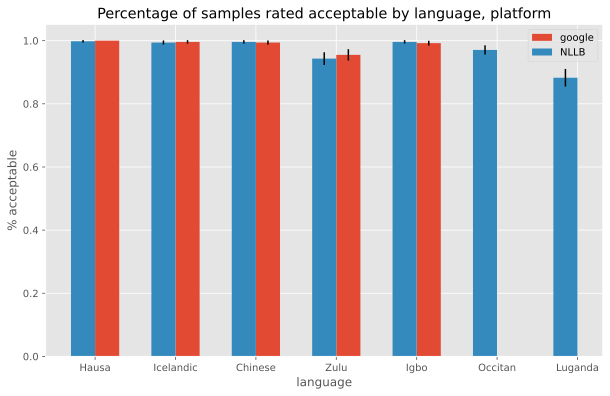

In [13]:
langs = 'hau isl zho_Hans zul ibo oci lug'.split()

sample_size = df[(df.target_lang == 'hau') & (df.platform == 'facebook')].score.values.shape[0]

fb_scores = [df[(df.target_lang == lang) & (df.platform == 'facebook')].score.values for lang in langs]
fb_percs = np.array([np.mean(x >= 3) for x in fb_scores])
fb_ses = np.array([np.sqrt(x * (1 - x) / sample_size) for x in fb_percs])

fb_domain = np.arange(len(fb_means))

google_scores = [df[(df.target_lang == lang) & (df.platform == 'google')].score.values for lang in langs]
google_percs = np.array([np.mean(x >= 3) for x in google_scores])
google_ses = np.array([np.sqrt(x * (1 - x) / sample_size) for x in google_percs])

google_domain = np.arange(len(google_means))

with plt.style.context('ggplot'):
    dot_size = 70
    bar_width=.3
    offset = bar_width / 2
    
    tick_domain = fb_domain
    ticks = [code_to_lang[x] for x in langs]
    
    plt.bar(google_domain + offset, google_percs, width=bar_width, label='google')
    plt.vlines(
        google_domain + offset, 
        google_percs - 1.96 * google_ses,
        google_percs + 1.96 * google_ses,
        color='black'
    )
    
    plt.bar(fb_domain - offset, fb_percs, width=bar_width, label='NLLB')
    plt.vlines(
        fb_domain - offset, 
        fb_percs - 1.96 * fb_ses,
        fb_percs + 1.96 * fb_ses,
        color='black'
    )
    
    plt.ylabel('% acceptable')
    plt.xlabel('language')
    
    # plt.ylim([1, 5])
    plt.xticks(tick_domain, ticks)
    # plt.yticks(range(1, 6))
    
    plt.legend(loc='upper right')
    plt.title('Percentage of samples rated acceptable by language, platform')
    plt.show();

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


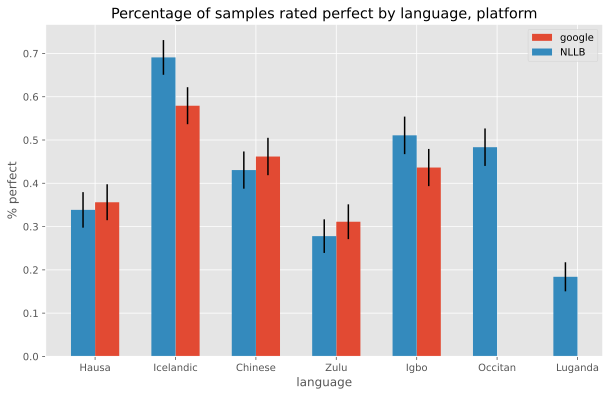

In [14]:
langs = 'hau isl zho_Hans zul ibo oci lug'.split()

sample_size = df[(df.target_lang == 'hau') & (df.platform == 'facebook')].score.values.shape[0]

fb_scores = [df[(df.target_lang == lang) & (df.platform == 'facebook')].score.values for lang in langs]
fb_percs = np.array([np.mean(x == 5) for x in fb_scores])
fb_ses = np.array([np.sqrt(x * (1 - x) / sample_size) for x in fb_percs])

fb_domain = np.arange(len(fb_means))

google_scores = [df[(df.target_lang == lang) & (df.platform == 'google')].score.values for lang in langs]
google_percs = np.array([np.mean(x == 5) for x in google_scores])
google_ses = np.array([np.sqrt(x * (1 - x) / sample_size) for x in google_percs])

google_domain = np.arange(len(google_means))

with plt.style.context('ggplot'):
    dot_size = 70
    bar_width=.3
    offset = bar_width / 2
    
    tick_domain = fb_domain
    ticks = [code_to_lang[x] for x in langs]
    
    plt.bar(google_domain + offset, google_percs, width=bar_width, label='google')
    plt.vlines(
        google_domain + offset, 
        google_percs - 1.96 * google_ses,
        google_percs + 1.96 * google_ses,
        color='black'
    )
    
    plt.bar(fb_domain - offset, fb_percs, width=bar_width, label='NLLB')
    plt.vlines(
        fb_domain - offset, 
        fb_percs - 1.96 * fb_ses,
        fb_percs + 1.96 * fb_ses,
        color='black'
    )
    
    plt.ylabel('% perfect')
    plt.xlabel('language')
    
    plt.xticks(tick_domain, ticks)
    
    plt.legend(loc='upper right')
    plt.title('Percentage of samples rated perfect by language, platform')
    plt.show()

Facet plot the distribution for each language

In [15]:
def get_hist_df(language, platform):
    mask = (df.target_lang_full == language) & (df.platform == platform)
    df_temp = df[mask]
    score_labels = np.arange(1, 6)
    percs = np.array([df_temp[df_temp.score == s].shape[0] for s in score_labels]) / df_temp.shape[0]
    
    return percs

get_hist_df('Hausa', 'facebook')

array([0.        , 0.00195695, 0.00195695, 0.65753425, 0.33855186])

/var/folders/c5/nkwg5qp52qb643c3zdsw3_dw0000gn/T/ipykernel_50337/526059293.py:5: RuntimeWarning: invalid value encountered in true_divide
  percs = np.array([df_temp[df_temp.score == s].shape[0] for s in score_labels]) / df_temp.shape[0]


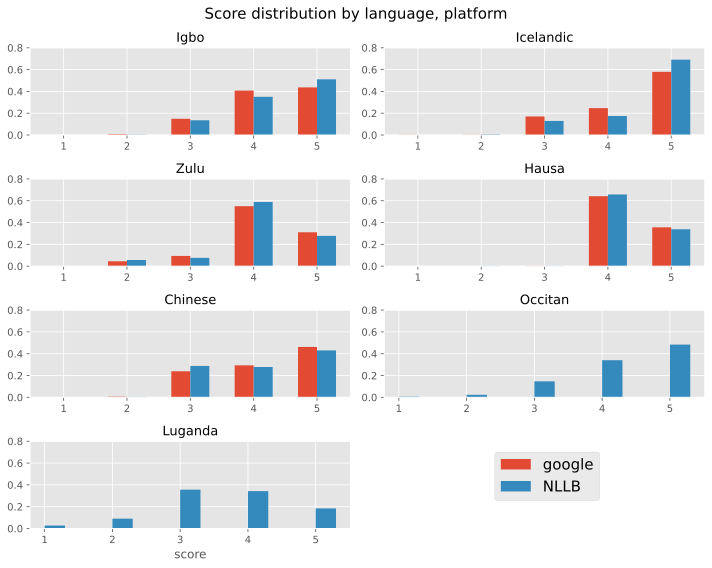

In [16]:
score_labels = np.arange(1, 6)
x_domain = np.arange(len(score_labels))


with plt.style.context('ggplot'):
    for i, lang in enumerate(df.target_lang_full.unique()):
        plt.rcParams['figure.figsize'] = 10, 8
        plt.subplot(4, 2, i+1)
        bar_width = .3
        
        plt.bar(x_domain - (bar_width / 2), get_hist_df(lang, 'google'), width=bar_width, label='google')
        plt.bar(x_domain + (bar_width / 2), get_hist_df(lang, 'facebook'), width=bar_width, label='NLLB')

        plt.xticks(x_domain, score_labels)
        plt.ylim([0, .8])
        plt.title(lang, size=13)

    plt.xlabel('score')
    plt.suptitle('Score distribution by language, platform', size=15)
    plt.tight_layout()
    plt.legend(loc=(1.45, .32), prop={'size': 15})

## Feature based analysis

Feature extraction functions

In [17]:
months = [calendar.month_name[i].lower() for i in range(1,13)]

def contains_date(doc):
    return any([m in doc.lower() for m in months])

def contains_number(doc):
    return bool(re.findall('[0-9]+', doc))

In [18]:
df = df.assign(
    contains_number=lambda df_: df_.source_segment.apply(contains_number),
    contains_month=lambda df_: df_.source_segment.apply(contains_date)
)

df.head()

,fbid,target_lang,target_lang_full,source_segment,target_segment,platform,paragraph_id,sentence_id,source_incoherence,target_incoherence,score,contains_number,contains_month
0,10093585_1a,ibo,Igbo,Juno Temple was born in the Hammersmith area o...,A mụrụ Juno Temple na mpaghara Hammersmith nke...,facebook,10093585,10093585_1,0,0,5,True,True
1,10093585_1d,isl,Icelandic,Juno Temple was born in the Hammersmith area o...,Juno Temple fæddist á Hammersmith svæðinu í Lo...,google,10093585,10093585_1,0,0,5,True,True
2,10093585_1d,zul,Zulu,Juno Temple was born in the Hammersmith area o...,UJuno Temple wazalelwa endaweni yaseHammersmit...,google,10093585,10093585_1,0,0,5,True,True
3,10093585_1e,hau,Hausa,Juno Temple was born in the Hammersmith area o...,An haifi Juno Temple a yankin Hammersmith na L...,facebook,10093585,10093585_1,0,0,4,True,True
4,10093585_1h,zho_Hans,Chinese,Juno Temple was born in the Hammersmith area o...,朱诺·坦普尔于1989年7月21日出生于伦敦哈默史密斯地区，是电影制片人阿曼达·皮里和电影导...,google,10093585,10093585_1,0,0,5,True,True


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:997: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:997: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))


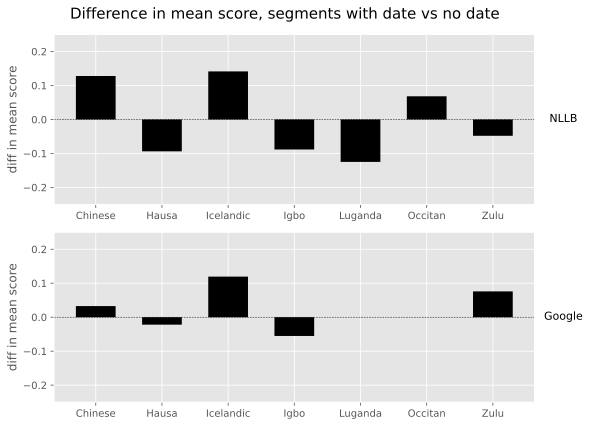

In [19]:
def get_color(val, p_val):
    
    color = '#000000'
    if p_val < .05:
        color = SOFT_GREEN if val > 0 else SOFT_RED
    
    return color

with plt.style.context('ggplot'):
    plt.rcParams['figure.figsize'] = 8, 6
    for i, platform in enumerate(('facebook', 'google')):
        languages = df.sort_values('target_lang_full').target_lang_full.unique()

        rows = []

        for language in languages:

            mask = (df.target_lang_full == language) & (df.platform == platform)
            has_month = df[mask & (df.contains_month == 1)]['score']
            no_month = df[mask & (df.contains_month == 0)]['score']
            
            t_stat, p_val, doff = ttest_ind(has_month, no_month)
            row = {
                'language': language,
                'has_month_mean': has_month.mean(),
                'no_month_mean': no_month.mean(),
                'diff_in_means': has_month.mean() - no_month.mean(),
                'p_val': p_val,
                'is_stat_sig': p_val < .05
            }

            rows.append(row)

        df_comparison = pd.DataFrame(rows)

        plt.subplot(2, 1, i+1)
        x_domain = np.arange(df_comparison.shape[0])
        bar_width = .6

        
        colors = [get_color(diff, p_val) for diff, p_val in df_comparison[['diff_in_means', 'p_val']].values]
        plt.bar(
            x_domain, 
            df_comparison.diff_in_means, 
            color=colors,
            width=bar_width
        )


        plt.axhline(0, linestyle='--', color='black', linewidth=.5)
        plt.ylim([-.25, .25])
        plt.ylabel('diff in mean score')
        
        plt.xticks(x_domain, df_comparison.language)
        plt.title('Google' if platform == 'google' else 'NLLB', y=.45, x=1.06, size=11)
    plt.suptitle('Difference in mean score, segments with date vs no date', size=15)
    plt.tight_layout()

In [20]:
df_comparison

,language,has_month_mean,no_month_mean,diff_in_means,p_val,is_stat_sig
0,Chinese,4.23762,4.20488,0.03275,0.72126,False
1,Hausa,4.33663,4.35854,-0.02190,0.68341,False
2,Icelandic,4.49505,4.37561,0.11944,0.17121,False
3,Igbo,4.22772,4.28293,-0.05520,0.50080,False
4,Luganda,NaN,NaN,NaN,NaN,False
5,Occitan,NaN,NaN,NaN,NaN,False
6,Zulu,4.18812,4.11220,0.07592,0.36586,False


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:997: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:997: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))


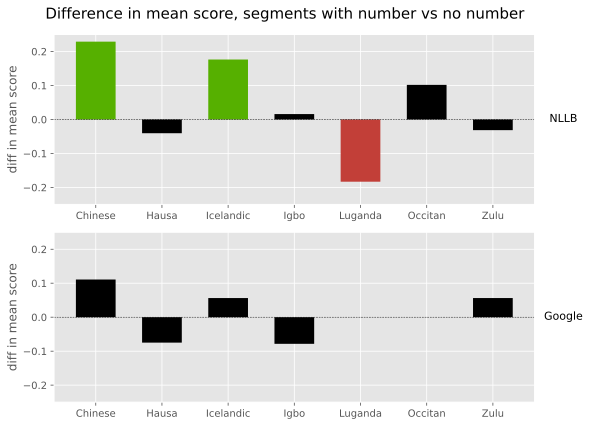

In [21]:
with plt.style.context('ggplot'):
    plt.rcParams['figure.figsize'] = 8, 6
    for i, platform in enumerate(('facebook', 'google')):
        languages = df.sort_values('target_lang_full').target_lang_full.unique()

        rows = []

        for language in languages:
            mask = (df.target_lang_full == language) & (df.platform == platform)
            has_number = df[mask & (df.contains_number == 1)]['score']
            no_number = df[mask & (df.contains_number == 0)]['score']
            
            if has_number.shape[0]:
                margin_of_error = 1.96 * np.sqrt(df[mask].score.var() / len(no_number))
            else:
                margin_of_error = 0
            t_stat, p_val, doff = ttest_ind(has_number, no_number)


            row = {
                'language': language,
                'has_number_mean': has_number.mean(),
                'no_number_mean': no_number.mean(),
                'diff_in_means': has_number.mean() - no_number.mean(),
                'margin_of_error': margin_of_error,
                'p_value': p_val,
                'is_stat_sig': p_val < .05
            }

            rows.append(row)
        df_comparison = pd.DataFrame(rows)
        
#------------------

        plt.subplot(2, 1, i+1)
        x_domain = np.arange(df_comparison.shape[0])
        bar_width = .6
        
        bar_colors = [get_color(val, p_val) for val, p_val in df_comparison[['diff_in_means', 'p_value']].values]

        plt.bar(
            x_domain, 
            df_comparison.diff_in_means, 
            color=bar_colors,
            width=bar_width
        )
        
        

        # for height, marker in zip(df_comparison.margin_of_error, x_domain):
        #     shade_width = bar_width * .7
        #     mini_domain = np.arange(marker - shade_width, marker + shade_width, .001)
        #     plt.fill_between(
        #         mini_domain, 
        #         height, 
        #         height * -1, 
        #         color='black',
        #         alpha=.15
        #     )

        plt.axhline(0, linestyle='--', color='black', linewidth=.5)
        plt.ylim([-.25, .25])
        plt.ylabel('diff in mean score')
        
        plt.xticks(x_domain, df_comparison.language)
        plt.title('Google' if platform == 'google' else 'NLLB', y=.45, x=1.06, size=11)
    plt.suptitle('Difference in mean score, segments with number vs no number', size=15)
    plt.tight_layout()

## Paragraph level evaluation

Is quality highly correlated with other sentences in the paragraph

In [22]:
(df
    .groupby(['target_lang_full', 'platform', 'paragraph_id'])
    .score
    .agg(subpar_rate=lambda x: np.mean(x < 3))
    .reset_index()
)

,target_lang_full,platform,paragraph_id,subpar_rate
0,Chinese,facebook,10093585,0.00000
1,Chinese,facebook,11848451,0.00000
2,Chinese,facebook,1256990,0.00000
3,Chinese,facebook,142528,0.00000
4,Chinese,facebook,14533,0.00000
...,...,...,...,...
1135,Zulu,google,731111,0.00000
1136,Zulu,google,736,0.00000
1137,Zulu,google,7412236,0.00000
1138,Zulu,google,773158,0.00000


/var/folders/c5/nkwg5qp52qb643c3zdsw3_dw0000gn/T/ipykernel_50337/2210926093.py:18: RuntimeWarning: Mean of empty slice.
  google_means = np.array([x.mean() for x in google_scores]) * 100
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/c5/nkwg5qp52qb643c3zdsw3_dw0000gn/T/ipykernel_50337/2210926093.py:19: RuntimeWarning: Degrees of freedom <= 0 for slice
  google_ses = np.array([np.sqrt(x.var() / len(x)) for x in google_scores])
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


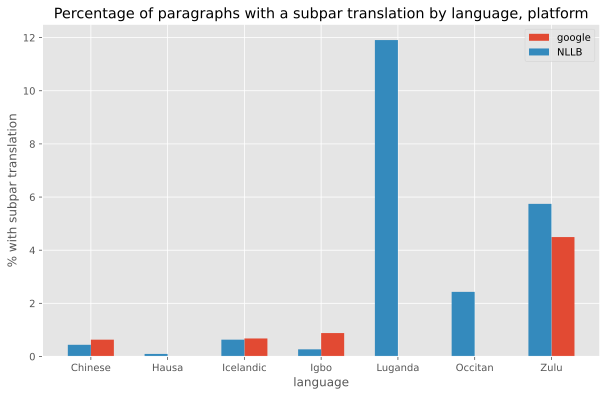

In [23]:
df_para = (
    df
    .groupby(['target_lang_full', 'platform', 'paragraph_id'])
    .score
    .agg(subpar_rate=lambda x: np.mean(x < 3))
    .reset_index()
)

languages = df_para.target_lang_full.unique()

fb_scores = [df_para[(df_para.target_lang_full == lang) & (df_para.platform == 'facebook')].subpar_rate.values for lang in languages]
fb_means = np.array([x.mean() for x in fb_scores]) * 100
fb_ses = np.array([np.sqrt(x.var() / len(x)) for x in fb_scores])

fb_domain = np.arange(len(fb_means))

google_scores = [df_para[(df_para.target_lang_full == lang) & (df_para.platform == 'google')].subpar_rate.values for lang in languages]
google_means = np.array([x.mean() for x in google_scores]) * 100
google_ses = np.array([np.sqrt(x.var() / len(x)) for x in google_scores])

google_domain = np.arange(len(google_means))

with plt.style.context('ggplot'):
    dot_size = 70
    bar_width=.3
    offset = bar_width / 2
    
    tick_domain = fb_domain
    ticks = [code_to_lang[x] for x in langs]
    
    plt.bar(google_domain + offset, google_means, width=bar_width, label='google')
    # plt.vlines(
    #     google_domain + offset, 
    #     google_means - 1.96 * google_ses,
    #     google_means + 1.96 * google_ses,
    #     color='black'
    # )
    
    plt.bar(fb_domain - offset, fb_means, width=bar_width, label='NLLB')
#     plt.vlines(
#         fb_domain - offset, 
#         fb_means - 1.96 * fb_ses,
#         fb_means + 1.96 * fb_ses,
#         color='black'
#     )
    
    plt.ylabel('% with subpar translation')
    plt.xlabel('language')
    
    # plt.ylim([1, 5])
    plt.xticks(fb_domain, languages)
    # plt.yticks(range(1, 6))
    
    plt.legend(loc='upper right')
    plt.title('Percentage of paragraphs with a subpar translation by language, platform')
    plt.show()

Anova test to determine if there's less variance between segments from the same paragraph that

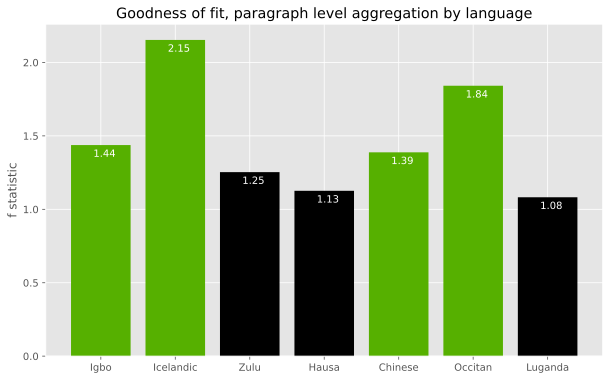

In [26]:
df_lang_pg_scores = df.groupby(['target_lang_full', 'paragraph_id']).score.agg(lambda x: list(x))

languages = df.target_lang_full.unique()
f_stats = [f_oneway(*df_lang_pg_scores[lang]) for lang in languages]
fs = [x.statistic for x in f_stats]
p_vals = [x.pvalue for x in f_stats]
x_domain = np.arange(len(languages))
colors = [get_color(1, p_val) for p_val in p_vals]


with plt.style.context('ggplot'):
    plt.bar(x_domain, fs, color=colors)
    plt.xticks(x_domain, languages)
    
    for i, f in enumerate(fs):
        plt.annotate(f'{f:.2f}', (i - .1, f - .08), color='white')
    
    plt.ylabel('f statistic')
    plt.title('Goodness of fit, paragraph level aggregation by language')
    # plt.

## Human eval vs BLEU

bleu scores from [this spreadsheet](https://docs.google.com/spreadsheets/d/16HANVGa-rmZcQnJVCTmEM8KxcivlHixdvNtCKR48Xr0/edit?usp=sharing)

In [27]:
bleu_scores = [
    33.6,
    34.7,
    41.6,
    28.4,
    18.3,
    47.7,
    38.5,
    30.32,
    40.72,
    40.34,
    25.28,
    33.52
]

In [29]:
df_w_bleu = (
    df
    .groupby(['platform', 'target_lang_full'])
    .score
    .mean()
    .reset_index()
    .assign(bleu_score=bleu_scores)   # the order is correct, feel free to validate it though
    .rename(columns={'score': 'human_eval_mean'})
)

df_w_bleu

,platform,target_lang_full,human_eval_mean,bleu_score
0,facebook,Chinese,4.13503,33.60000
1,facebook,Hausa,4.33268,34.70000
2,facebook,Icelandic,4.54990,41.60000
3,facebook,Igbo,4.36791,28.40000
4,facebook,Luganda,3.56556,18.30000
5,facebook,Occitan,4.27202,47.70000
6,facebook,Zulu,4.08806,38.50000
7,google,Chinese,4.21135,30.32000
8,google,Hausa,4.35421,40.72000
9,google,Icelandic,4.39922,40.34000


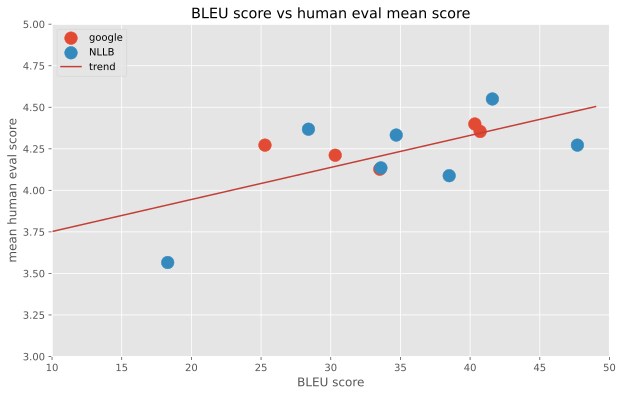

In [30]:
with plt.style.context('ggplot'):
    
    x_min = 10
    x_max = 50
    
    data = sm.add_constant(df_w_bleu[['human_eval_mean', 'bleu_score']])
    model = sm.OLS.from_formula(formula='human_eval_mean ~ bleu_score', data=data).fit()
    # model = sm.OLS(data.human_eval_mean,  data[['const', 'bleu_score']]).fit()
    
    x_domain = np.arange(x_min, x_max)
    line = model.params[0] + model.params[1] * x_domain
    
    size = 160
    alpha = 1.
    google_data = df_w_bleu.query('platform == "google"')
    fb_data = df_w_bleu.query('platform == "facebook"')
    
    plt.scatter(google_data.bleu_score, google_data.human_eval_mean, s=size, label='google', alpha=alpha)
    plt.scatter(fb_data.bleu_score, fb_data.human_eval_mean, s=size, label='NLLB', alpha=alpha)
    plt.plot(x_domain, line, color=SOFT_RED, label='trend')
    
    plt.xlim([x_min, x_max])
    plt.ylim([3, 5])
    
    plt.ylabel('mean human eval score')
    plt.xlabel('BLEU score')
    
    plt.legend(loc='upper left')
    plt.title('BLEU score vs human eval mean score')
    plt.show()

In [32]:
data = sm.add_constant(df_w_bleu[['human_eval_mean', 'bleu_score']])

model = sm.OLS(data.human_eval_mean,  data[['const', 'bleu_score']]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        human_eval_mean   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     6.774
Date:                Mon, 11 Apr 2022   Prob (F-statistic):             0.0264
Time:                        16:44:32   Log-Likelihood:                 3.4746
No. Observations:                  12   AIC:                            -2.949
Df Residuals:                      10   BIC:                            -1.979
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5593      0.261     13.620      0.0

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## Mann Whitney U Test

Just to see how different the result is when we use a non-parametric test. The resulting p values shouldn't be too different.

In [33]:
langs = []
u_pvals = []
t_pvals = []


for lang in df.target_lang_full.unique():
    df_temp = df[df.target_lang_full == lang]
    
    if df_temp.platform.unique().shape[-1] == 1:
        continue
        
    u_pval = mannwhitneyu(
        df_temp[df_temp.platform == 'facebook'].score,
        df_temp[df_temp.platform == 'google'].score,
    ).pvalue
    
    t_pval = ttest_ind(
        df_temp[df_temp.platform == 'facebook'].score,
        df_temp[df_temp.platform == 'google'].score
    )[1]
    
    langs.append(lang)
    u_pvals.append(u_pval)
    t_pvals.append(t_pval)
    
pd.DataFrame({
    'language': langs,
    'u_pval': u_pvals,
    't_pval': t_pvals
})

,language,u_pval,t_pval
0,Igbo,0.02696,0.03643
1,Icelandic,0.00047,0.00160
2,Zulu,0.40917,0.40845
3,Hausa,0.52845,0.47857
4,Chinese,0.15289,0.14480
